Diego Escobedo

# 6.S083 / 18.S190 Spring 2020: Problem set 5

Submission deadline: Tuesday May 11, 2020 at 10:00pm EDT.

We started off this course by looking at some real-world *data* on the COVID-19 epidemic.
Most of the course has been about how to define and implement mathematical and computational *models*.

Models have *parameters*, e.g. the rate of recovery from infection. Where do the values of these parameters come from? Ideally we extract them from data. The goal of this problem set, then, is to put everything together by *fitting* a model to data.

In order to keep things as simple as possible, we will use data that we generated from the spatial model in Problem Set 4, rather than real-world data, and we will fit the simplest SIR model (the ODE version). But the same basic ideas apply in the more general context.

There are several ways to fit a function to data, but all in the end involve some form of **optimization**, usually **minimization** of a special function called a **loss function**, which measures how far we currently are away from our goal. This forms the basis of the vast and key field of **machine learning**. Indeed, machine learning is just "fitting a model to some data by optimizing over the parameters". In this problem set we will build up the tools we need to find the parameters in the SIR equations that best fit the data.

We emphasize that this material is intended to be pedagogical; we are not suggesting that the specific techniques here are the ones you should use for an actual calculation, but the underlying ideas are what are important.

This is a capstone problem set that replaces two problem sets (two weeks' work) and hence is a little longer than usual.

### Exercise 1: Simulating the SIR differential equations

Recall that the ordinary differential equations (ODEs) for the SIR model are as follows:

\begin{align*}
\dot{S} &= - \beta S I \\
\dot{I} &=  \beta S I - \gamma I \\
\dot{R} &= \gamma I
\end{align*}

where we use the notation $\dot{S} := \frac{dS}{dt}$ for the derivative of $S$ with respect to time. $S$ represents the *proportion* (fraction) of the population that is susceptible.

We will use the simplest possible method to simulate these, namely the **Euler method**. The Euler method is *not* a good method to solve ODEs accurately. But for our purposes it is good enough.

For an ODE with a single variable, $\dot{x} = f(x)$, the Euler method takes steps of length $h$ in time. If we have an approximation $x_n$ at time $t_n$ it gives us an approximation for the value $x_{n+1}$ of $x$ at time $t_{n+1} = t_n + h$ as

$$x_{n+1} = x_n + h \, f(x_n)$$

In the case of several functions $S$, $I$ and $R$, we must use a rule like this for *each* of the differential equations within a *single* time step to get new values for *each* of $S$, $I$ and $R$ at the end of the time step in terms of the values at the start of the time step. In Julia we can write `S` for the old value and `S_new` for the new value.

1. Implement a function `euler_SIR(β, γ, S0, I0, R0, h, T)` that integrates these equations with the given parameter values and initial values, with a step size $h$ up to a final time $T$.

    It should return vectors of the trajectory of $S$, $I$ and $R$, as well as the collection of times at which they are calculated.

In [7]:
function euler_SIR(β, γ, S0, I0, R0, h, T)
    S = Float64[]
    I = Float64[]
    R = Float64[]
    S_old = S0
    I_old = I0
    R_old = R0
    for i in 1:T
        S_new = S_old + h*(-β*S_old*I_old)
        I_new = I_old + h*(β*S_old*I_old - γ*I_old)
        R_new = R_old + h*(γ*I_old)
        push!(S,S_new)
        push!(I,I_new)
        push!(R,R_new)
        S_old = S_new
        I_old = I_new
        R_old = R_new
    end
    return S, I, R, collect(1:T)
end

euler_SIR (generic function with 1 method)

2. Run the SIR model with $\beta = 0.1$, $\gamma = 0.05$, and $S_0 = 0.99$, $I_0 = 0.01$ and $R_0 = 0$ for a time $T = 300$ with $h=0.1$. Plot $S$, $I$ and $R$ as a function of time $t$.

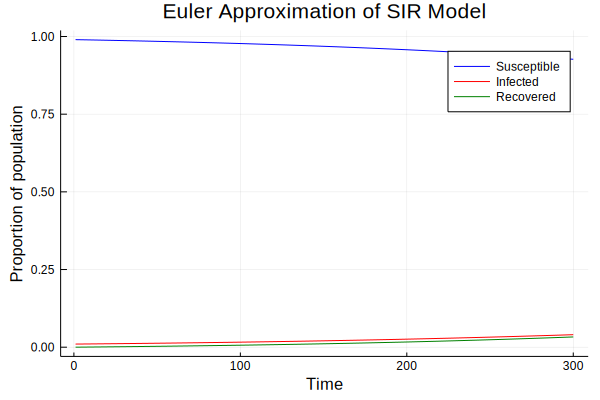

In [8]:
using Plots
β = 0.1
γ = 0.05
S_0 = 0.99
I_0 = 0.01
R_0 = 0
T = 300
h = 0.1
S, I, R, long = euler_SIR(β, γ, S_0, I_0, R_0, h, T)
plot(title = "Euler Approximation of SIR Model", xlabel = "Time", ylabel = "Proportion of population")
plot!(long, S, c=:blue, label = "Susceptible")
plot!(long, I, c=:red, label = "Infected")
plot!(long, R, c=:green, label = "Recovered")


3. Do you see an epidemic outbreak (i.e. a rapid growth in number of infected individuals, followed by a decline)? What happens after a long time? Does everybody get infected?

No, it appears as if the infection rate $\beta$ was not large enough to cause an epidemic

4. Make an interactive visualization in which you can vary $\beta$ and $\gamma$. What relation should $\beta$ and $\gamma$ have for an epidemic outbreak to occur?

In [11]:
using Interact
@manipulate for β in 0:0.01:1, γ in 0:0.01:1
    S_0 = 0.99
    I_0 = 0.01
    R_0 = 0
    T = 300
    h = 0.1
    S, I, R, long = euler_SIR(β, γ, S_0, I_0, R_0, h, T)
    plot(title = "Euler Approximation of SIR Model", xlabel = "Time", ylabel = "Proportion of population")
    plot!(long, S, c=:blue, label = "Susceptible")
    plot!(long, I, c=:red, label = "Infected")
    plot!(long, R, c=:green, label = "Recovered")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["β"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 101,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000383cf0f0, Task (runnable) @0x00000000383cf0f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.01\",\"0.02\",\"0.03\",\"0.04\",\"0.05\",\"0.06\",\"0.07\",\"0.08\",\"0.09\",\"0.1\",\"0.11\",\"0.12\",\"0.13\",\"0.14\",\"0.15\",\"0.16\",\"0.17\",\"0.18\",\"0.19\",\"0.2\",\"0

We get a pretty reasonable outbreak visual if we use $\gamma = 0.1$ and $\beta = 0.6$

### Exercise 2: Numerical derivatives

For fitting we need optimization, and for optimization we will use *derivatives*. So in this question we see one method for calculating derivatives numerically.

1. Define a function `deriv` that takes a function $f: \mathbb{R} \to \mathbb{R}$, a number $a$ and an optional $h$ with default value 0.001, and calculates the finite difference approximation

    $$f'(a) \simeq \frac{f(a + h) - f(a)}{h}$$

    of the derivative $f'(a)$.

In [12]:
function deriv(f, a, h=0.001)
    return (f(a+h)-f(a))/h
end

deriv (generic function with 2 methods)

2. Write a function `tangent_line` that calculates the tangent line to $f$ at a point $a$. It should also accept a value of $x$ at which it will calculate the height of the tangent line. Use the function `deriv` to calculate $f'(a)$.

In [13]:
function tangent_line(f,a,x)
    f_prime = deriv(f,a)
    point_on_line = f_prime*(x-a) + f(a)
end

tangent_line (generic function with 1 method)

3. Make an interactive visualization of the function $f(x) = x^3 - 2x$, showing the tangent line at a point $a$ and allowing you to vary $a$.
Make sure that the line is indeed visually tangent to the graph!

In [44]:
f(x) = x^3 - 2x
@manipulate for a in -2:0.1:2
    plot(collect(-2:0.01:2),collect([f(i) for i in -2:0.01:2]), c=:blue, label = "x^3 - 2x", title = "Tangent Lines")
    plot!(collect(-2:0.1:2), collect([tangent_line(f,a,x) for x in -2:0.1:2]), c=:orange, label = "Tangent Line at a = $a")
    xlims!((-2,2))
    ylims!((-5,5))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["a"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 41,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
21, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000013c91710, Task (runnable) @0x0000000013c91710), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-2.0\",\"-1.9\",\"-1.8\",\"-1.7\",\"-1.6\",\"-1.5\",\"-1.4\",\"-1.3\",\"-1.2\",\"-1.1\",\"-1.0\",\"-0.9\",\"-0.8\",\"-0.7\",\"-0.6\",\"-0.5\",\"-0.4\",\"-0.3\",\"-0.2\",\"-0.1\",\"0.0\",\"

4. Write functions `∂x(f, a, b)` and `∂y(f, a, b)` that calculate the **partial derivatives** $\frac{\partial f}{\partial x}$ and $\frac{\partial f}{\partial y}$ at $(a, b)$ of a function $f : \mathbb{R}^2 \to \mathbb{R}$ (i.e. a function that takes two real numbers and returns one real).

    Recall that $\frac{\partial f}{\partial x}$  is the derivative of the single-variable function $g(x) := f(x, b)$ obtained by fixing the value of $y$ to $b$.

    You should use **anonymous functions** for this. These have the form `x -> x^2`, meaning "the function that sends $x$ to $x^2$".

In [46]:
function ∂x(f, a, b)
    return deriv(x->f(x,b),a)
end
function ∂y(f, a, b)
    return deriv(y->f(a,y),b)
end;

5. Write a function `gradient(f, a, b)` that calculates the **gradient** of a function $f$ at the point $(a, b)$, given by the vector $\nabla f(a, b) := (\frac{\partial f}{\partial x}(a, b), \frac{\partial f}{\partial y}(a, b))$.

In [170]:
function gradient(f, a, b)
   return  collect([∂x(f, a, b) ; ∂y(f, a, b)])
end

gradient (generic function with 1 method)

### Exercise 3: Minimization using gradient descent

In this exercise we will use **gradient descent** to find local **minima** of (smooth enough) functions.

To do so we will think of a function as a hill. To find a minimum we should "roll down the hill".



1. Write a function `gradient_descent_1d(f, x0)` to minimize a 1D function, i.e. a function $f: \mathbb{R} \to \mathbb{R}$.

    To do so we notice that the derivative tells us the direction in which the function *increases*. So we take steps in the *opposite* direction, of a small size $\eta$ (eta).

    Use this to write the function starting from the point `x0` and using your function `deriv` to approximate the derivative.

    Take a reasonably large number of steps, say 100, with $\eta = 0.01$.

    What would be a better way to decide when to end the function?

In [193]:
function gradient_descent_1d(f, x0, T = 100, η = 0.01)
    xs = Float64[]
    x = x0
    for i in 1:T
        x = x - η*deriv(f,x)
        push!(xs,x)
    end
    return xs
end

gradient_descent_1d (generic function with 3 methods)

2. Write an interactive visualization showing the progress of gradient descent on the function

    $$f(x) = x^{4} +3x^{3} - 3x + 5$$

    Make sure that it does indeed get close to a local minimum.

    How can you find different local minima?

In [194]:
f(x) = x^4 + 3x^3 - 3x + 5
x0 = -.6
xs = gradient_descent_1d(f, x0)
@manipulate for i in 1:length(xs)
    plot(collect([-4:0.01:2]), collect([f(x) for x in -4:0.01:2]), c=:blue, label = "x^4 +3x^3 - 3x + 5" )
    xlims!((-4,2))
    ylims!((0,10))
    scatter!([xs[i]], [f(xs[i])], m=:o, label = "Step $i of Gradient Descent")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 100,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
50, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000383cee10, Task (runnable) @0x00000000383cee10), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",

Yes, depending on your start point you can get a different minimum

3.  Write a function `gradient_descent_2d(f, x0, y0)` that does the same for functions $f(x, y)$ of two variables.

    Multivariable calculus tells us that the gradient $\nabla f(a, b)$ at a point $(a, b)$ is the direction in which the function *increases* the fastest. So again we should take a small step in the *opposite* direction.

In [198]:
function gradient_descent_2d(f, x0, y0; T = 100, η = 0.01)
    record = Array{Float64,1}[]
    θ = collect([x0 ; y0])
    for i in 1:T
        θ = θ - η*gradient(f,θ[1],θ[2])
        push!(record,θ)
    end
    return record
end

gradient_descent_2d (generic function with 3 methods)

4. Apply this to the **Himmelblau function** $f(x, y) := (x^2 + y - 11)^2 + (x + y^2 - 7)^2$. Visualize the trajectory using both contours (`contour` function) and a 2D surface (`surface` function).

    Can you find different minima?

    You can try to install the `PlotlyJS` and (if necessary) `ORCA` packages and activate it with `using Plots; plotlyjs()`. This will / should give an *interactive* 3D plot. (But don't spend time on it if it doesn't immediately work.)

In [220]:
himmelblau(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
x0 = 0
y0 = 0
r = gradient_descent_2d(himmelblau, x0, y0);

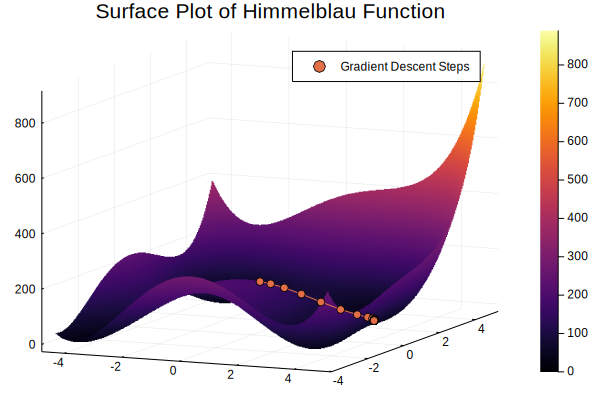

In [221]:
surface(-4.5:0.01:5, -3.8:0.01:5, himmelblau, title = "Surface Plot of Himmelblau Function")
plot!(collect([r[i][1] for i in 1:length(r)]), collect([r[i][2] for i in 1:length(r)]), collect([himmelblau(r[i][1],r[i][2]) for i in 1:length(r)]), m=:o, label = "Gradient Descent Steps")

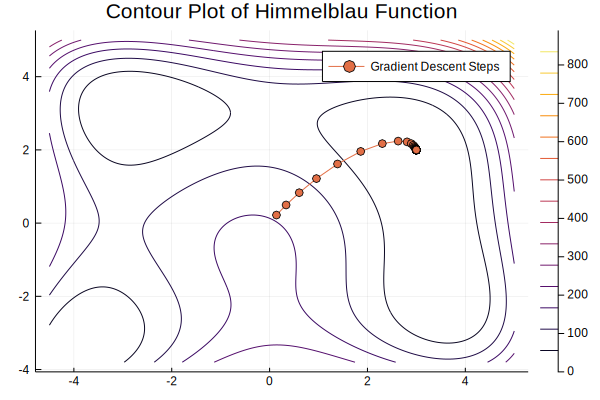

In [222]:
contour(-4.5:0.01:5, -3.8:0.01:5, himmelblau, title = "Contour Plot of Himmelblau Function")
plot!(collect([r[i][1] for i in 1:length(r)]), collect([r[i][2] for i in 1:length(r)]), m=:o, label = "Gradient Descent Steps")

Unfortunately the ORCA package was giving me some serious errors and the last part didn't work :(

### Exercise 4: Learning parameter values

In this exercise we will apply gradient descent to fit a simple function $y = f_{a, b}(x)$ to some data given as pairs $(x_i, y_i)$. Here $a$ and $b$ are **parameters** that appear in the form of the function $f$. We want to find the parameters that **best fit** to the given data.

To do so we need to define what "best" means. We will define a measure of the distance between the function and the data, given by a **loss function**, which itself depends on the values of $a$ and $b$. Then we will *minimize* the loss function over $a$ and $b$ to find those values that minimize this distance, and hence are "best" in this precise sense.

The iterative procedure by which we gradually adjust the parameter values to improve the loss function is often called **machine learning** or just **learning**, since the computer is "discovering" information in a gradual way, which is supposed to remind us of how humans learn. [It doesn't, and it's not.]


1. Load the data from the file `some_data.csv` into vectors `xs` and `ys`.

In [223]:
using CSV
data = CSV.read("some_data.csv")
xs = collect(data[!,1])
ys = collect(data[!,2]);

2. Plot the data. What does it remind you of?

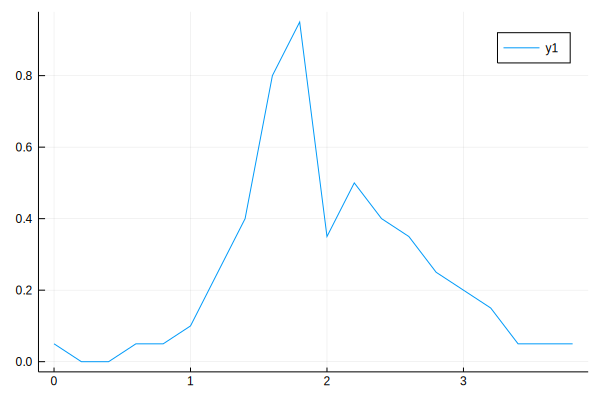

In [202]:
using Plots
gr()
plot(xs,ys)

It sort of reminds me of a normal distribution

3. Let's try to fit a gaussian (normal) distribution. Its PDF with mean $\mu$ and standard deviation $\sigma$ is

    $$f_{\mu, \sigma}(x) := \frac{1}{\sigma \sqrt{2 \pi}}\exp \left[- \frac{(x - \mu)^2}{2 \sigma^2} \right]$$

    Define this function as `f(x, μ, σ)`.

In [203]:
normal(x, μ, σ) = (1/(σ*√(2*π)))*exp(-(x-μ)^2/(2*σ^2))

normal (generic function with 1 method)

4. Define a **loss function** to measure the "distance" between the actual data and the function. It will depend on the values of $\mu$ and $\sigma$ that you choose:

    $$ \mathcal{L}(\mu, \sigma) := \sum_i [f_{\mu, \sigma}(x_i) - y_i]^2 $$

In [204]:
function L(μ,σ)
    s = 0
    for i in 1:length(xs)
        s += (normal(xs[i], μ, σ) - ys[i])^2
    end
    return s
end

L (generic function with 1 method)


5. Use your `gradient_descent` function to find a local minimum of $\mathcal{L}$, starting with initial values $\mu = 0$ and $\sigma = 1$.

    What are the final values for $\mu$ and $\sigma$ that you find?

In [225]:
μ₀ = 0
σ₀ = 1
descent_hist = gradient_descent_2d(L, μ₀, σ₀, T = 600)
mu_final = descent_hist[end][1]
sigma_final = descent_hist[end][2]
print("final values are mu= $mu_final , sigma = $sigma_final")

final values are mu= 1.8876875610812411 , sigma = 0.5821116835711495

6. Modify the gradient descent function to store the whole history of the values of $\mu$ and $\sigma$ that it went through.

    Make an interactive visualization showing how the resulting curve $f_{\mu, \sigma}$ evolves over time, compared to the original data.

    ("Time" here corresponds to the iterations in the gradient descent function.)

In [226]:
@manipulate for i in 1:length(descent_hist)
    mu_cur = descent_hist[i][1]
    sigma_cur = descent_hist[i][2] 
    plot(xs,ys, label = "Given Data", title = "Gradient Descent Predicted Distribution vs Actual")
    plot!(collect(-1:0.01:5), collect([normal(x,mu_cur,sigma_cur) for x in -1:0.01:5]), label = "Predicted Distribution at step $i",legend=:topright)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 600,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
300, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000e834f6b0, Task (runnable) @0x00000000e834f6b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\"

### Exercise 5: Putting it all together -- fitting an SIR model to data

In this exercise we will fit the (non-spatial) SIR ODE model from Exercise 1 to the (spatial) data you generated in Problem Set 4. If we are able to find a good fit, that might (or might not) constitute evidence that space "does not matter" too much for the dynamics of these models. If the fit is not so good, perhaps there is an important effect of space. (As usual in statistics, and indeed in modelling in general, we should cautious of making categorical claims.)

This fitting procedure will be different from that in Exercise 4, however: we no longer have an explicit form for the function that we are fitting! So what should we do?

We will try to find the parameters $\beta$ and $\gamma$ for which *the output of the ODEs when we simulate it with those parameters* best matches the data!

1. Re-run your spatial simulation from Problem Set 4 for a bigger system and make sure there is an epidemic outbreak for the parameters you use.

    Save the data to a CSV file from that notebook, using the following code. You may need to install the `Tables` package.

    ```julia
    using CSV, Tables

    CSV.write("mydata.csv", Tables.table(M))
    ```

    where `M` is a matrix storing $t$, $S$, $I$ and $R$ as a function of time $t$ in separate columns.

    If you have vectors, you can make them into a matrix using `hcat(ts, Ss, Is, Rs)`. If you prefer, you can make a dataframe instead.

Done!

2. Load your data into the current notebook. Make sure to include this data in a zip file with your notebook when you submit the pset.

    Extract the data into vectors `ts`, `Ss`, `Is` and `Rs`.

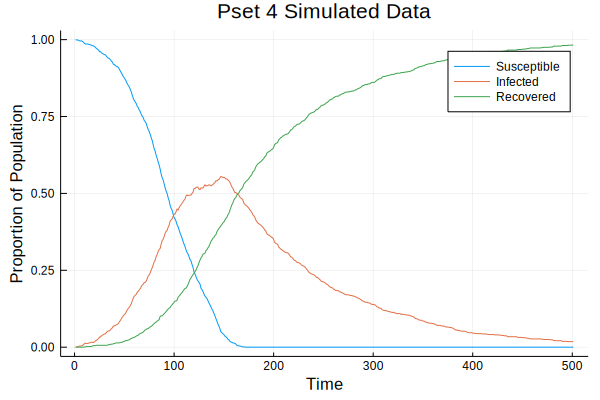

In [274]:
data = CSV.read("mydata.csv")
ts = collect(data[!,1])
Ss = collect(data[!,2])./1000
Is = collect(data[!,3])./1000
Rs = collect(data[!,4])./1000
plot(ts, Ss, label = "Susceptible", title = "Pset 4 Simulated Data", xlabel = "Time", ylabel = "Proportion of Population")
plot!(ts, Is, label = "Infected")
plot!(ts, Rs, label = "Recovered")

3. Make a loss function $\mathcal{L}(\beta, \gamma)$. This will compare *the solution of the SIR equations* with parameters $\beta$ and $\gamma$ with your data.

    To do this, once we have generated the solution of the SIR equations with parameters $\beta$ and $\gamma$, we must evaluate that solution at times $t$ from the vector `ts`, so that we can compare with the data at that time.

    Normally we would do this by some kind of **interpolation** (fitting a function locally through nearby data points). As a cheap alternative, we will just use the results corresponding to the closest value $t'$ with $t' < t$ that does occur in the solution of the ODEs. Write a function to calculate this value.

    (You should be able to do it *without* searching through the whole vector. Hint: Use the fact that the times are equally spaced.)

    The loss function should take the form

    $$\mathcal{L} = \mathcal{L}_S + 2 \mathcal{L}_I + \mathcal{L}_R$$

    where e.g. $\mathcal{L}_S$ is the loss function for the $S$ data, defined as in [4.4]. The factor 2 weights $I$ more heavily, since the behaviour of $I$ is what we particularly care about, so we want to fit that better. You should experiment with different weights to see what effect it has.

In [275]:
function L_sir(β,γ)
    β = max(β,0)
    γ = abs(γ)
    S_0 = 0.999
    I_0 = 0.001
    R_0 = 0
    T = 501
    h = 0.1
    S_euler, I_euler, R_euler, time_euler = euler_SIR(β, γ, S_0, I_0, R_0, h, T)
    return L_s(S_euler, time_euler) + 2*L_i(I_euler, time_euler) + L_r(R_euler, time_euler)
end
    
function L_s(S_euler::Array{Float64,1}, time_euler)
    s = 0
    for measurement_index in 1:length(Ss)
        observed_susceptible = Ss[measurement_index]
        predicted_susceptible = S_euler[floor(measurement_index)]
        s += (observed_susceptible - predicted_susceptible)^2
    end
    return s
end
function L_i(I_euler::Array{Float64,1}, time_euler)
    s = 0
    for measurement_index in 1:length(Is)
        observed_infected = Is[measurement_index]
        predicted_infected = I_euler[floor(measurement_index)]
        s += (observed_infected - predicted_infected)^2
    end
    return s
end
function L_r(R_euler::Array{Float64,1}, time_euler)
    s = 0
    for measurement_index in 1:length(Rs)
        observed_recovered = Rs[measurement_index]
        predicted_recovered = R_euler[floor(measurement_index)]
        s += (observed_recovered - predicted_recovered)^2
    end
    return s
end

L_r (generic function with 1 method)

4. Minimize the loss function and make an interactive visualization of how the solution of the SIR model compares to the data, as the parameters change during the gradient descent procedure.

    If you made it this far, congratulations -- you have just taken your first step into the exciting world of scientific machine learning!

In [287]:
β₀ = 1
γ₀ = 1
descent_hist = gradient_descent_2d(L_sir, β₀, γ₀, T = 600, η=0.0001)
beta_final = descent_hist[end][1]
gamma_final = descent_hist[end][2]
print("final values are beta= $beta_final , gamma = $gamma_final")

final values are beta= 0.8404797887351737 , gamma = 0.1055042135328384

In [288]:
@manipulate for i in 1:length(descent_hist)
    beta_cur = descent_hist[i][1]
    gamma_cur = descent_hist[i][2]
    S_euler, I_euler, R_euler, time_euler = euler_SIR(beta_cur, gamma_cur, S_0, I_0, R_0, h, T)
    plot(ts, Ss, label = "Susceptible", title = "PS 4 Simulation vs GD (step $i) Fitting", xlabel = "Time", ylabel = "Proportion of Population")
    plot!(time_euler, S_euler, label = "Predicted Susceptible")
    plot!(ts, Is, label = "Infected")
    plot!(time_euler, I_euler, label = "Predicted Infected")
    plot!(ts, Rs, label = "Recovered")
    plot!(time_euler, R_euler, label = "Predicted Recovered")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 600,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
300, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000013c985d0, Task (runnable) @0x0000000013c985d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\"